## Colab Cells

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ugs-applications/

/content/drive/MyDrive/ugs-applications


## Instal Packages

In [3]:
!pip3 install transformer_lens
!pip3 install seaborn
!pip3 install fancy_einsum
!pip3 install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.9 MB/s eta 0:00:00
  Using cached nvid

## Imports

In [4]:
import torch
import numpy as np
from tqdm import tqdm
from fancy_einsum import einsum
import math
from functools import partial
import torch.optim
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
from einops import repeat
from utils.circuit_utils import prune_dangling_edges, discretize_mask
from utils.training_utils import load_model_data
from utils.MaskConfig import VertexInferenceConfig
import argparse
import os
from utils.task_datasets import IOIConfig
from utils.task_datasets import get_task_ds
from utils.training_utils import load_model_data, LinePlot, update_means_variances_mixed, update_means_variances
from pruners.VertexPruner import VertexPruner
from mask_samplers.AblationMaskSampler import SingleComponentMaskSampler

In [5]:
try:
    parser = argparse.ArgumentParser()
    parser.add_argument('-s', '--subfolder',
                        help='where to save stuff')
    args = parser.parse_args()
    subfolder = args.subfolder
except:
    subfolder = None

if subfolder is not None:
    folder=f"atp/{subfolder}"
else:
    folder=f"atp/ioi"

if not os.path.exists(folder):
    os.makedirs(folder)

usage: colab_kernel_launcher.py [-h] [-s SUBFOLDER]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-22106823-b4c7-49f4-bc51-07220d990b2c.json


## Multi Component Sampler

In [138]:
# for gradient sampling
class MultiComponentMaskSampler(torch.nn.Module):
    def __init__(self, pruning_cfg, prop_sample=0.1):
        super().__init__()

        self.sampled_mask = None

        self.use_temperature = False
        self.log_columns = []

        self.pruning_cfg = pruning_cfg

        self.n_layers = pruning_cfg.n_layers
        self.n_heads = pruning_cfg.n_heads
        self.device = pruning_cfg.device

        self.prop_sample = prop_sample

        self.mask_perturb = torch.nn.ParameterDict({
            "attn": torch.nn.ParameterList([
                torch.nn.Parameter(torch.zeros((self.n_heads,)).to(self.device))
                for i in range(self.n_layers)
            ]),
            "mlp": torch.nn.ParameterList([
                torch.nn.Parameter(torch.zeros((1,)).to(self.device))
                for i in range(self.n_layers)
            ])
        })

    def forward(self):
        bsz = self.pruning_cfg.batch_size * self.pruning_cfg.n_samples

        total_heads = self.n_layers * self.n_heads
        #sampled_heads = math.ceil(self.prop_sample * total_heads)
        sampled_heads = 1

        # select random subset
        ref_idx = torch.arange(bsz).unsqueeze(-1).repeat(1, sampled_heads)
        _, top_k_idx = torch.rand((bsz, total_heads)).topk(sampled_heads, dim=-1)

        attn_mask = torch.ones((bsz, total_heads)).to(self.device)
        attn_mask[ref_idx.flatten(), top_k_idx.flatten()] = 0

        attn_mask = attn_mask + (1-attn_mask) * (
            torch.rand_like(attn_mask).to(self.device) +
            torch.stack([param for param in self.mask_perturb['attn']], dim=0).flatten()
        )

        attn_mask = attn_mask.unflatten(1, (self.n_layers, -1))

        self.sampled_mask = {
            "attn": [
                attn_mask[:, i]
                for i in range(self.n_layers)
            ],
            "mlp": [
                torch.ones((bsz)).to(self.device)
                for i in range(self.n_layers)
            ]
        }
        return 0, {}

    def record_state(self, j):
        pass

## Run Multi Component Sampler

In [218]:
ablation_type = "mean_agnostic"
dataset = "ioi"
n_samples = 10
batch_size = 1
model_name = "gpt2-small"
owt_batch_size = 10
prop_sample = 0.1

In [219]:
device, model, tokenizer, owt_iter = load_model_data(model_name, owt_batch_size)
model.eval()
# model.cfg.use_attn_result = True
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads

pruning_cfg = VertexInferenceConfig(model.cfg, device, folder, init_param=1)
pruning_cfg.batch_size = batch_size
pruning_cfg.n_samples = n_samples

task_ds = get_task_ds(dataset, pruning_cfg.batch_size, device, ablation_type)

for param in model.parameters():
    param.requires_grad = False

print("Dataset Config", task_ds.__dict__)

pruner_args = task_ds.get_pruner_args({"zero", "mean", "resample", "cf_mean", "cf", "oa", "oa_specific","mean_agnostic"})

mask_sampler = MultiComponentMaskSampler(pruning_cfg, prop_sample=prop_sample)

mask_sampler()
print("Attn mask shape per layer", mask_sampler.sampled_mask["attn"][0].shape)
print("MLP mask shape per layer", mask_sampler.sampled_mask["mlp"][0].shape)

vertex_pruner = VertexPruner(model, pruning_cfg, mask_sampler, **pruner_args)
vertex_pruner.add_patching_hooks()

vertex_pruner.modal_attention.requires_grad = False
vertex_pruner.modal_mlp.requires_grad = False


Loading model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loading OWT...
Loading OWT data from disk
Making DataLoader
Dataset Config {'ds_name': 'ioi', 'batch_size': 1, 'device': device(type='cuda', index=0), 'ablation_type': 'mean_agnostic', 'means': None, 'ds': <list_iterator object at 0x7ac235fe69b0>, 'seed': 0, 'fix_prompt': False}
Attn mask shape per layer torch.Size([10, 12])
MLP mask shape per layer torch.Size([10])


In [220]:
def update_means_vars(prev_means, prev_vars, batch_results, n_batches_by_head, n_samples_by_head, batch_samples_by_head):
    # computing variance iteratively using a trick
    new_batches_by_head = n_batches_by_head + (batch_samples_by_head > 0).sum(dim=-1, keepdim=True)
    new_samples_by_head = n_samples_by_head + batch_samples_by_head.sum(dim=-1, keepdim=True)


    means = prev_means * n_samples_by_head

    means = means + (batch_samples_by_head * batch_results).sum(dim=-1, keepdim=True)
    means = torch.where(
        new_samples_by_head > 0,
        means / new_samples_by_head,
        means
    )

    prev_vars = prev_vars * (n_batches_by_head - 1)
    vars = prev_vars + (batch_samples_by_head * (batch_results - prev_means).square()).sum(dim=-1, keepdim=True) - new_samples_by_head * (means - prev_means).square()

    vars = torch.where(
        new_batches_by_head > 1,
        vars / (new_batches_by_head - 1),
        vars
    )

    return means, vars, new_batches_by_head, new_samples_by_head

In [221]:
sampling_optimizer = torch.optim.AdamW(mask_sampler.parameters(), lr=1, weight_decay=0)
head_losses = torch.zeros((n_layers * n_heads,1)).to(device)
head_vars = torch.zeros((n_layers * n_heads,1)).to(device)
n_batches_by_head = torch.zeros_like(head_losses).to(device)
n_samples_by_head = torch.zeros_like(head_losses).to(device)

high_losses = torch.zeros((1,)).to(device)

max_batches = 10000


for no_batches in tqdm(range(vertex_pruner.log.t, max_batches)):
    batch, last_token_pos,cf = task_ds.retrieve_batch_cf(tokenizer)
    last_token_pos = last_token_pos.int()

    sampling_optimizer.zero_grad()

    loss = vertex_pruner(batch, last_token_pos,timing = False, print_loss = False)
    loss.backward()

    atp_losses = torch.cat([ts.grad for ts in mask_sampler.mask_perturb['attn']], dim=0).unsqueeze(-1)

    batch_n_samples = []
    for ts in mask_sampler.sampled_mask['attn']:
        batch_n_samples.append((ts < 1-1e-3).sum(dim=0))
    batch_n_samples = torch.cat(batch_n_samples, dim=0).unsqueeze(-1)



    # atp_losses = torch.where(
    #     batch_n_samples > 0,
    #     atp_losses,
    #     0
    # )

    n_samples_by_head += batch_n_samples
    head_losses += atp_losses


    #head_losses, head_vars, n_batches_by_head, n_samples_by_head = update_means_variances_mixed(head_losses, head_vars, atp_losses, n_batches_by_head, n_samples_by_head, batch_n_samples)

    # if no_batches % -100 == -1:
    #     sns.scatterplot(
    #         x=head_losses.cpu().flatten(),
    #         y=head_vars.sqrt().cpu().flatten()
    #     )
    #     plt.xlabel("attention head mean loss")
    #     plt.ylabel("attention head std loss")
    #     plt.show()


  2%|▏         | 209/10000 [00:23<18:21,  8.89it/s]


KeyboardInterrupt: 

In [223]:
atp_losses[atp_losses != 0]

tensor([-2.9039e-04, -3.3640e-05, -2.3721e-04, -8.4266e-05, -2.0003e-04,
        -9.2607e-05, -8.7684e-05, -3.9777e-05, -9.4702e-05, -3.3507e-03],
       device='cuda:0')

In [217]:
atp_losses[atp_losses != 0].mean()

tensor(-0.0056, device='cuda:0')

In [224]:
single_component_head_losses[:144] / (head_losses /n_samples_by_head )

tensor([[ -35.0347],
        [ -10.3206],
        [  -5.7763],
        [  -8.2418],
        [ -12.7130],
        [  -5.8039],
        [  -8.2640],
        [ -13.9227],
        [ -10.8107],
        [ -12.0563],
        [ -16.9997],
        [ -12.9749],
        [ -20.9968],
        [  -9.1098],
        [  -7.8599],
        [ -11.1558],
        [ -14.1686],
        [  -7.1120],
        [  -8.9098],
        [  -5.7961],
        [  -7.4065],
        [  -6.9026],
        [  -7.3741],
        [ -20.1691],
        [  -2.9630],
        [  -7.3470],
        [ -20.5682],
        [ -14.7438],
        [ -42.0607],
        [  -9.2212],
        [  -6.0094],
        [ -15.3341],
        [  -7.8625],
        [ -17.7377],
        [  -7.9859],
        [ -24.5363],
        [  -8.4551],
        [  -9.6352],
        [ -15.1392],
        [ -10.0534],
        [  -9.6929],
        [  -3.6861],
        [  -9.5280],
        [-115.5137],
        [ -47.3857],
        [  -6.5720],
        [ -11.5261],
        [ -37

In [200]:
atp_losses

tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [-3.1180e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.2350e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.0438e-06],
        [ 0.0000e+00],
        [-2.0969e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-4.8829e-06],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-1.1724e-05],
        [-4.0910e-06],
        [ 0.0000e+00],
        [-1.9043e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-4.9862e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-6.7766e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0

In [201]:
torch.cat([ts.grad for ts in mask_sampler.mask_perturb['attn']], dim=0).unsqueeze(-1)

tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [-3.1180e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.2350e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.0438e-06],
        [ 0.0000e+00],
        [-2.0969e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-4.8829e-06],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-1.1724e-05],
        [-4.0910e-06],
        [ 0.0000e+00],
        [-1.9043e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-4.9862e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-6.7766e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0

In [202]:
head_losses

tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [-3.1180e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.2350e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-2.0438e-06],
        [ 0.0000e+00],
        [-2.0969e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-4.8829e-06],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-1.1724e-05],
        [-4.0910e-06],
        [ 0.0000e+00],
        [-1.9043e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-4.9862e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [-6.7766e-05],
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0

In [189]:
(single_component_head_losses[:144]/ (head_losses/ n_samples_by_head)).mean()

tensor(-54.3091, device='cuda:0')

In [44]:
with open(folder + "/multi_component_head_losses.pkl", "wb") as f:
    pickle.dump(head_losses, f)
with open(folder + "/multi_component_head_vars.pkl", "wb") as f:
    pickle.dump(head_vars, f)

In [88]:
head_losses.mean()

tensor(-0.0002, device='cuda:0')

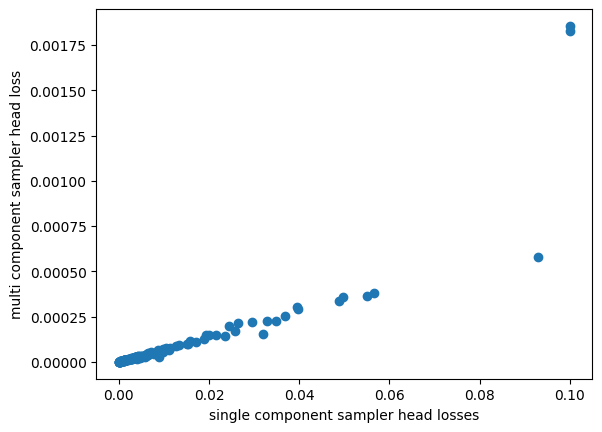

In [145]:
from sklearn.metrics import r2_score

single_component_head_losses = pickle.load(open(folder + "/single_component_head_losses.pkl", "rb"))
single_component_head_vars = pickle.load(open(folder + "/single_component_head_vars.pkl", "rb"))


plt.scatter(single_component_head_losses[:144].cpu().clip(max=0.1), (head_losses.cpu() * -1).clip(max=0.1))


plt.xlabel('single component sampler head losses')
plt.ylabel('multi component sampler head loss')
plt.show()

In [60]:
r2_score(single_component_head_losses.cpu()[:144].log(), (head_losses.cpu() * -1).log())

ValueError: Input contains NaN.

## Run Single Component Sampler

In [121]:
model_name = "gpt2-small"
owt_batch_size = 10
device, model, tokenizer, owt_iter = load_model_data(model_name, owt_batch_size)
model.eval()
# model.cfg.use_attn_result = True
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads

for param in model.parameters():
    param.requires_grad = False

pruning_cfg = VertexInferenceConfig(model.cfg, device, folder, init_param=1)

pruning_cfg.batch_size = batch_size


mask_sampler = SingleComponentMaskSampler(pruning_cfg)
pruning_cfg.n_samples = mask_sampler.n_components

print("Attn mask shape per layer", mask_sampler.sampled_mask["attn"][0].shape)
print("MLP mask shape per layer", mask_sampler.sampled_mask["mlp"][0].shape)


task_ds = get_task_ds(dataset, pruning_cfg.batch_size, device, ablation_type)

pruner_args = task_ds.get_pruner_args({"zero", "mean", "resample", "cf_mean", "cf", "oa", "oa_specific","mean_agnostic"})

vertex_pruner = VertexPruner(model, pruning_cfg, mask_sampler, **pruner_args)
vertex_pruner.add_patching_hooks()

Loading model...
Loaded pretrained model gpt2-small into HookedTransformer
Loading OWT...
Loading OWT data from disk
Making DataLoader
Attn mask shape per layer torch.Size([156, 12])
MLP mask shape per layer torch.Size([156])


In [122]:
max_batches = 10000 // pruning_cfg.batch_size
single_component_head_losses = torch.zeros((pruning_cfg.n_samples,1)).to(device)
single_component_head_vars = torch.zeros((pruning_cfg.n_samples,1)).to(device)

In [123]:
for no_batches in tqdm(range(max_batches)):
    batch, last_token_pos, cf = task_ds.retrieve_batch_cf(tokenizer)

    with torch.no_grad():
        # loss: [n_components, batch_size]
        loss, _ = vertex_pruner(batch, last_token_pos, counterfactual=cf, separate_loss=True,timing = False, print_loss = False)
        single_component_head_losses, single_component_head_vars = update_means_variances(single_component_head_losses, single_component_head_vars, loss, no_batches)
        break


  0%|          | 0/10000 [00:00<?, ?it/s]


In [124]:
loss

tensor([[1.9835e-03],
        [4.4732e-01],
        [6.0579e-03],
        [1.6800e-02],
        [2.8127e-02],
        [9.9530e-03],
        [4.9891e-03],
        [7.6500e-03],
        [2.5986e-02],
        [4.8783e-02],
        [8.0617e-02],
        [2.0319e-03],
        [4.2516e-03],
        [2.1765e-02],
        [8.3824e-03],
        [6.8741e-04],
        [3.4386e-03],
        [3.2056e-03],
        [4.5775e-03],
        [1.5842e-02],
        [8.7332e-03],
        [1.9136e-03],
        [1.3995e-03],
        [5.2852e-03],
        [2.5573e-02],
        [1.6719e-02],
        [4.7787e-03],
        [8.1625e-04],
        [2.1302e-02],
        [1.5352e-02],
        [1.7544e-03],
        [7.8483e-04],
        [5.3487e-02],
        [5.2778e-02],
        [1.7558e-03],
        [5.6691e-03],
        [6.6351e-03],
        [3.0283e-03],
        [5.4011e-03],
        [5.4478e-02],
        [1.4306e-03],
        [1.0139e-02],
        [2.2801e-02],
        [2.3210e-01],
        [2.5886e-02],
        [2

In [89]:
with open("single_component_head_losses.pkl", "wb") as f:
    pickle.dump(single_component_head_losses, f)
with open("single_component_head_vars.pkl", "wb") as f:
    pickle.dump(single_component_head_vars, f)

In [94]:
single_component_head_losses

torch.Size([156, 1])

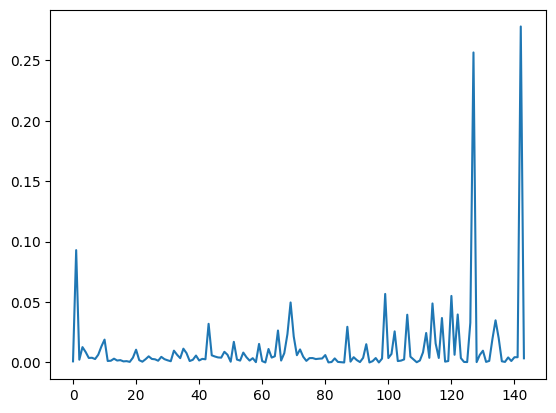

In [97]:
single_component_head_losses_without_outlier = single_component_head_losses[:144][single_component_head_vars[:144] < .1]
plt.plot(np.arange(len(single_component_head_losses_without_outlier)), single_component_head_losses_without_outlier.cpu().numpy())
plt.show()

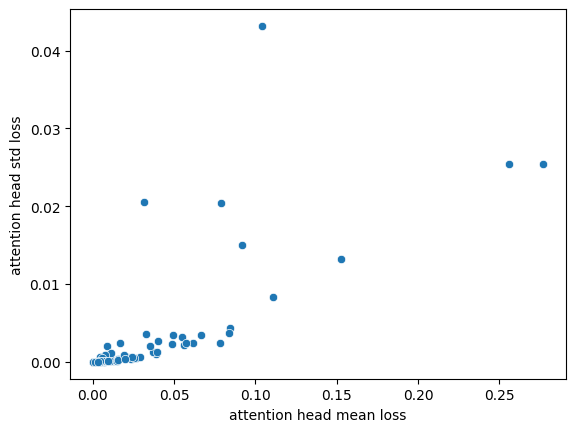

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the outlier from single_component_head_vars
single_component_head_vars_without_outlier = single_component_head_vars[single_component_head_vars < 1]
single_component_head_losses_without_outlier = single_component_head_losses[single_component_head_vars < 1]
# Plot single_component_head_vars_without_outlier against single_component_head_losses
sns.scatterplot(
    x=single_component_head_losses_without_outlier.cpu().flatten(),
    y=single_component_head_vars_without_outlier.cpu().flatten()
)

plt.xlabel("attention head mean loss")
plt.ylabel("attention head std loss")
plt.show()


In [49]:
single_component_head_losses[0]

tensor([0.0009], device='cuda:0')

In [38]:
loss.shape

torch.Size([156, 1])

In [42]:
mask_sampler.sampled_mask